In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
# Parameters
num_pevgs = 5  # Number of PEVGs
grid_capacity = 99  # Total energy available from the grid (MWh)
max_iterations = 100  # Maximum number of iterations
population_size = 100  # Number of particles
local_search_iterations = 10  # Number of local search iterations
delta = 0.5  # Local search parameter

In [3]:

# Bounds
price_lower_bound = 20  # Lower bound for price (USD/MWh)
price_upper_bound = 60  # Upper bound for price (USD/MWh)
battery_capacity_lower_bound = 35  # Lower bound for battery capacity (MWh)
battery_capacity_upper_bound = 65  # Upper bound for battery capacity (MWh)


# PEVG parameters

In [4]:
battery_capacities = np.random.uniform(battery_capacity_lower_bound, battery_capacity_upper_bound, num_pevgs)  # Battery capacities (MWh)
satisfaction_parameters = np.random.uniform(1, 2, num_pevgs)  # Satisfaction parameters


# Initialize population

In [5]:

def initialize_population(population_size, num_pevgs, grid_capacity, price_lower_bound, price_upper_bound):
    population = []
    for _ in range(population_size):
        energy_demands = np.random.uniform(0, grid_capacity, num_pevgs)
        energy_demands = energy_demands / np.sum(energy_demands) * grid_capacity
        price = np.random.uniform(price_lower_bound, price_upper_bound)  # Initial price (USD/MWh)
        population.append((energy_demands, price))
    return population

# Objectives

In [6]:

# Utility function for PEVGs
def utility_function(energy_demands, price, battery_capacities, satisfaction_parameters):
    utilities = battery_capacities * energy_demands - 0.5 * satisfaction_parameters * energy_demands**2 - price * energy_demands
    return utilities

In [7]:
# Revenue function for the grid
def revenue_function(energy_demands, price):
    return price * np.sum(energy_demands)

In [8]:
# Constraint handling: Ensure total energy demand <= grid capacity
def handle_constraints(energy_demands, grid_capacity):
    total_demand = np.sum(energy_demands)
    if total_demand > grid_capacity:
        energy_demands = energy_demands / total_demand * grid_capacity
    return energy_demands

# Local search

In [9]:

def local_search(particle, battery_capacities, satisfaction_parameters, grid_capacity, delta, price_lower_bound, price_upper_bound):
    energy_demands, price = particle
    for _ in range(local_search_iterations):
        new_energy_demands = energy_demands + delta * np.random.uniform(-1, 1, num_pevgs)
        new_energy_demands = np.clip(new_energy_demands, 0, grid_capacity)
        new_energy_demands = handle_constraints(new_energy_demands, grid_capacity)
        new_price = price + delta * np.random.uniform(-1, 1)
        new_price = np.clip(new_price, price_lower_bound, price_upper_bound)
        if np.sum(new_energy_demands) <= grid_capacity:
            energy_demands, price = new_energy_demands, new_price
    return energy_demands, price

In [10]:
# Check if one solution dominates another
def dominates(solution1, solution2):
    # solution1 dominates solution2 if it is better in at least one objective and not worse in any other
    better_in_one = False
    for i in range(len(solution1)):
        if solution1[i] < solution2[i]:
            return False
        if solution1[i] > solution2[i]:
            better_in_one = True
    return better_in_one

# Update Pareto front

In [11]:

def update_pareto_front(pareto_front, new_solution):
    # Add new_solution to the Pareto front if it is not dominated by any existing solution
    to_remove = []
    for i, solution in enumerate(pareto_front):
        if dominates(solution, new_solution):
            return pareto_front  # new_solution is dominated, do not add it
        if dominates(new_solution, solution):
            to_remove.append(i)  # existing solution is dominated by new_solution
    # Remove dominated solutions
    pareto_front = [solution for j, solution in enumerate(pareto_front) if j not in to_remove]
    # Add new_solution to the Pareto front
    pareto_front.append(new_solution)
    return pareto_front

In [12]:
# def update_pareto_front(pareto_front, new_solutions):
#     res = []
#     for i in range(len(pareto_front)):
#         if dominates(pareto_front[i], new_solutions[i]):
#             res.append(pareto_front[i])
#         elif dominates( new_solutions[i] , pareto_front[i]):
#             res.append(new_solutions[i])
#     return res

# EMA algorithm

In [13]:

def ema_algorithm(num_pevgs, grid_capacity, battery_capacities, satisfaction_parameters, population_size, max_iterations, delta, price_lower_bound, price_upper_bound):
    population = initialize_population(population_size, num_pevgs, grid_capacity, price_lower_bound, price_upper_bound)
    pareto_front = []  # Initialize Pareto front
    
    for iteration in range(max_iterations):
        # Evaluate fitness
        fitness = []
        for particle in population:
            energy_demands, price = particle
            utilities = utility_function(energy_demands, price, battery_capacities, satisfaction_parameters)
            revenue = revenue_function(energy_demands, price)
            fitness.append((np.sum(utilities), revenue))

        # if(len(pareto_front) == 0): 
        #     pareto_front = fitness
        # else: 
        #     pareto_front = update_pareto_front(pareto_front, fitness)
        
        # Update Pareto front
        for i in range(population_size):
            pareto_front = update_pareto_front(pareto_front, fitness[i])
        
        # Calculate forces
        forces = []
        for i in range(population_size):
            force = np.zeros(num_pevgs + 1)
            for j in range(population_size):
                if i != j:
                    diff = np.array(list(population[j][0]) + [population[j][1]]) - np.array(list(population[i][0]) + [population[i][1]])
                    force += diff / np.linalg.norm(diff)**2
            forces.append(force)
        
        # Move particles
        for i in range(population_size):
            energy_demands, price = population[i]
            force = forces[i]
            new_energy_demands = energy_demands + delta * force[:-1]
            new_price = price + delta * force[-1]
            new_energy_demands = np.clip(new_energy_demands, 0, grid_capacity)
            new_energy_demands = handle_constraints(new_energy_demands, grid_capacity)
            new_price = np.clip(new_price, price_lower_bound, price_upper_bound)
            population[i] = (new_energy_demands, new_price)
        
        # Local search
        for i in range(population_size):
            population[i] = local_search(population[i], battery_capacities, satisfaction_parameters, grid_capacity, delta, price_lower_bound, price_upper_bound)
    
    # Return Pareto front
    return pareto_front , population



In [14]:
# Run EMA algorithm
pareto_front , particles = ema_algorithm(num_pevgs, grid_capacity, battery_capacities, satisfaction_parameters, population_size, max_iterations, delta, price_lower_bound, price_upper_bound)

In [15]:
# # Print Pareto front
# print("Pareto Front Solutions:")
# for i, solution in enumerate(pareto_front):
#     print(f"Solution {i + 1}: Utilities = {solution[0]}, Revenue = {solution[1]}")

In [16]:
X = []
Y = []
for objective in pareto_front:
    X.append(objective[1])
    Y.append(objective[0])


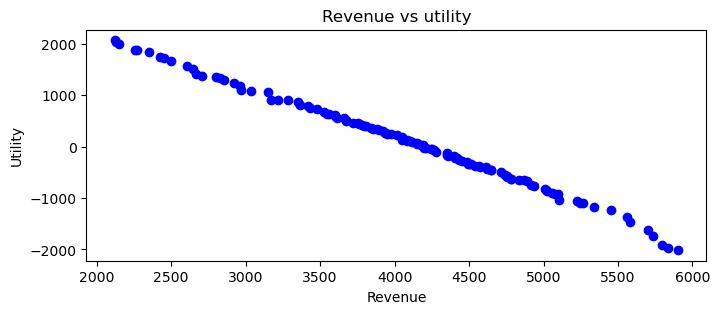

In [17]:
plt.figure(figsize=(8,3))
plt.scatter(X,Y , color="b")
plt.title("Revenue vs utility")
plt.xlabel("Revenue")
plt.ylabel("Utility")
# plt.savefig('EMA_n_5.jpg')
plt.show()

In [18]:
Y = []
N = num_pevgs
for i in range(N):
    Y.append([])
    
for i in range(10):
    part = particles[i][0]
    for j in range(len(part)):
        Y[j].append(part[j])


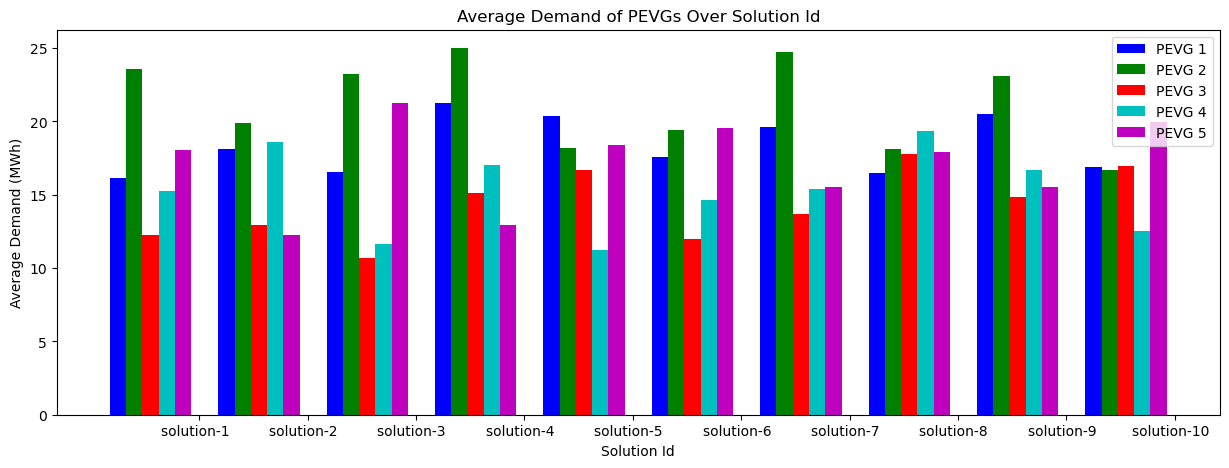

In [19]:
# Colors for different PEVGs
colors = ['b', 'g', 'r', 'c', 'm']
total = 10
x = np.arange(total)
bar_width = 0.15

# Plot bars for each PEVG
plt.figure(figsize=(15, 5))
for i in range(N):
    plt.bar( x + i * bar_width, Y[i], width=bar_width, color=colors[i], label=f'PEVG {i+1}')


# Labels and Title
plt.xlabel('Solution Id')
plt.ylabel('Average Demand (MWh)')
plt.title('Average Demand of PEVGs Over Solution Id')
plt.xticks(x + bar_width * (N ), [f'solution-{i+1}  ' for i in range(total)])  # Adjust X-ticks
plt.legend()
# plt.savefig('EMA_top_10.jpg')
plt.show()